_____________________________________________________
# 3. Inference

________________________________________

In [1]:
# load the necessary
import matplotlib.pylab as plt
%matplotlib inline
import os
import numpy as np
import sys
print('Python version:',sys.version)
import tensorflow as tf
print('TF version:',tf.__version__)


Python version: 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TF version: 1.8.0


____________________________
## Generating the output

> Load the trained model and pass the test images using feed_dict

In [2]:
# Load the test images
import glob
from PIL import Image
MODEL_DIR = './unet_model'
TEST_DATA_PATH = 'segmentation_test'
img_files = sorted(glob.glob(os.path.join(TEST_DATA_PATH, '%s*' %'*.jpg')))

def preprocess_img(img):
    img = Image.open(img)
    h, w = img.size[0], img.size[1]
    img = img.resize((64*(h//64), 64*(w//64)))
    return np.asarray(img)/255., h, w              

def save_img(img, h, w, file_name):
    name = os.path.basename(file_name)
    img = Image.fromarray(img*255.)
    img = img.resize((h,w))
    img = img.convert('RGB')
    img.save(os.path.join('out',name), quality=95)

# Loading the trained model
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load the graph with the trained states
    loader = tf.train.import_meta_graph(MODEL_DIR+'.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    #Get the tensors by their variable name
    prediction = loaded_graph.get_tensor_by_name('pred:0')
    X = loaded_graph.get_tensor_by_name('X:0')
    y = loaded_graph.get_tensor_by_name('y:0')
    is_train = loaded_graph.get_tensor_by_name('is_train:0')
    
    out = []
    inp = []
    for img in img_files:
        img_scaled, h, w = preprocess_img(img)
        pred = sess.run(prediction, feed_dict={is_train:False, X:np.expand_dims(img_scaled, 0)})
        save_img(np.squeeze(pred), h, w, img)
        out.append(pred)
        inp.append(img_scaled)
    
    print('Outputs generated...')

INFO:tensorflow:Restoring parameters from ./unet_model
Outputs generated...


(-0.5, 575.5, 831.5, -0.5)

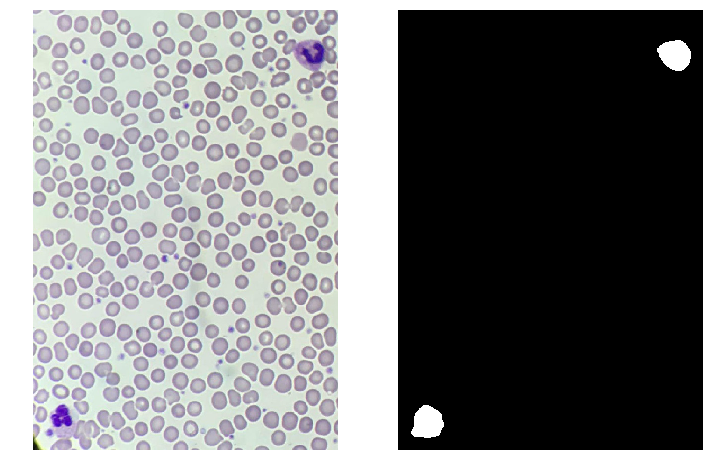

In [10]:
plt.figure(figsize=(12, 10))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(inp[6]))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(out[6]), cmap='gray')
plt.axis('off')

_________________________
## Summary

> 1. Unet - A fully convolutional network is implemented   
> 2. Data augmentation is done to compensate for smaller training data  
> 3. The input data pipeline feeding the NN runs on CPU, while the NN runs on GPU, to have parallelism.  

